In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
#Convert a collection of raw documents to a matrix of TF-IDF features.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import regex
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import re
import string
from transformers import TFBertModel, TFBertPreTrainedModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample

In [3]:
# %run SheidaTalei_Preprocessing_FinalProject.ipynb
!pip install transformers

     |████████████████████████████████| 1.3MB 20.1MB/s 
     |████████████████████████████████| 2.9MB 56.4MB/s 
     |████████████████████████████████| 1.1MB 48.6MB/s 
     |████████████████████████████████| 890kB 42.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=4b3986d8403fe7336930074172e252e0a26013eccf4022fef60d4465d5406f5b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
#------------------------------------------Empty Rows Removal----------------------------------------------------------------
# This function Will: 1- Remove all empty rows from csv file 2- Save data to the same csv
def removeEmptyRows(fileName):
    df = pd.read_csv(fileName, encoding='utf-8-sig')
    df = df.dropna(subset=['text'], how='all', axis=0) 
    df.to_csv(fileName, header=True, encoding='utf-8-sig',  index=False)
    
    return df

In [9]:
file_name = "/content/drive/My Drive/Final/cleanData_train.pkl"
open_file = open(file_name, "rb")
lemmatize_tweet_list = pickle.load(open_file)
open_file.close()

In [10]:
file_name = "/content/drive/My Drive/Final/cleanData_test.pkl"
open_file = open(file_name, "rb")
lemmatize_tweet_list_test = pickle.load(open_file)
open_file.close()

In [ ]:
def convertSequenceWordsToText(input_list, dataFrame, fileName):
    X_and_Y = pd.read_csv(dataFrame , encoding="utf-8")
    text = ''
    counter = 0
    for item in input_list:
        for i in range(len(item)):
            text += list(item)[i] + ' '
        print(counter)    
        X_and_Y.loc [counter, 'text'] = text.strip()
        X_and_Y.to_csv(fileName ,index=False, encoding='utf-8-sig')
        counter = counter + 1
        text =''

In [ ]:
convertSequenceWordsToText(lemmatize_tweet_list, 'X_and_Y.csv' , 'X_and_Y_train_LSTM.csv')

In [ ]:
convertSequenceWordsToText(lemmatize_tweet_list_test,'X_and_Y_test.csv', 'X_and_Y_test_LSTM.csv')

In [11]:

removeEmptyRows('/content/drive/My Drive/Final/X_and_Y_train_LSTM.csv')

X_and_Y = pd.read_csv('/content/drive/My Drive/Final/X_and_Y_train_LSTM.csv',encoding="utf-8")
X_train = X_and_Y.text
Y_train= X_and_Y.Label

# #Tokenization
# train_data_tokenize_list = tokenization (X)
#------------------------------------------------------test---------------------------------------------------------------------
#step 2: Tokenizing data


removeEmptyRows('/content/drive/My Drive/Final/X_and_Y_test_LSTM.csv')
X_and_Y_test = pd.read_csv('/content/drive/My Drive/Final/X_and_Y_test_LSTM.csv',encoding="utf-8")
X_test = X_and_Y_test.text
Y_test= X_and_Y_test.Label

# #Tokenization
# train_data_tokenize_list_test = tokenization (X_test)

In [ ]:
#source:
#https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
#https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
#https://sci2lab.github.io/ml_tutorial/bert_farsi_sentiment/

In [12]:
#We need to transform our data into a format BERT understands. 
# data is a dataFrame
def convert_data_into_input_example(data):
    """ Covert the list of examples into a list of `InputExample` objects that is suitable
        for BERT model."""
    input_examples = []
    for i in range(len(data)):
        example = InputExample(
            guid= None,
            text_a= data.iloc[i][ 'text'], #  is the text we want to classify
            text_b= None,
            label= data.iloc[i][ 'Label'] #is the label of our example, i.e. 1 or 0.
        )
        input_examples.append(example)
    return input_examples

In [13]:
train_input_examples = convert_data_into_input_example(X_and_Y)
val_input_examples = convert_data_into_input_example(X_and_Y_test)

In [16]:
train_input_examples[0]

InputExample(guid=None, text_a='کلکسیونی افتخارات ورزش شهید', text_b=None, label=0.0)

In [17]:

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

# text = 'I liked that book very much!'
# tokenized_text = tokenizer.tokenize(text)
# print(tokenized_text)
# text_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
# print('text ids:', text_ids)
# text_ids_with_special_tokens = tokenizer.build_inputs_with_special_tokens(text_ids)
# print('text ids with special tokens: ', text_ids_with_special_tokens)

In [18]:
#Tokenization
label_list = [0.0, 1.0]
MAX_SEQ_LENGTH = 128
bert_train_dataset = glue_convert_examples_to_features(examples=train_input_examples, tokenizer=tokenizer, max_length=MAX_SEQ_LENGTH, task='mrpc', label_list=label_list)
bert_val_dataset = glue_convert_examples_to_features(examples=val_input_examples, tokenizer=tokenizer, max_length=MAX_SEQ_LENGTH, task='mrpc', label_list=label_list)

# for i in range(3):
# #     print('Example: {}'.format(bert_train_dataset[i]))
#     print('Example: {')
#     print(' Input_ids: {}'.format(bert_train_dataset[i].input_ids))
#     print(' attention_mask: {}'.format(bert_train_dataset[i].attention_mask))
#     print(' token_type_ids: {}'.format(bert_train_dataset[i].token_type_ids))
#     print(' label: {}'.format(bert_train_dataset[i].label))
#     print('}')

/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:175: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


In [21]:
#for myself
ex = bert_train_dataset[0]
in_ids = ex.input_ids
decoded_sentence = tokenizer.decode(in_ids, skip_special_tokens=True)
print(decoded_sentence)

کلکسیونی افتخارات ورزش شهید


In [22]:
#Defining the Hyperparameters
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metric_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# # metrics_AUC = tf.keras.metrics.AUC(curve='ROC')
# model.compile(optimizer=optimizer, loss=loss, metrics=[metric_accuracy ])

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# metrics_AUC = tf.keras.metrics.AUC(curve='ROC')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric_accuracy ])

In [23]:
#training the model
# model.fit(bert_train_dataset, validation_data=bert_val_dataset, epochs=3)
def my_solution(bdset):
    """ Create a list of input tensors required to be in the first argument of the
        model call function for training. e.g. `model([input_ids, attention_mask, token_type_ids])`.
    """
    input_ids, attention_mask, token_type_ids, label = [], [], [], []
    for in_ex in bdset:
        input_ids.append(in_ex.input_ids)
        attention_mask.append(in_ex.attention_mask)
        token_type_ids.append(in_ex.token_type_ids)
        label.append(in_ex.label)

    input_ids = np.vstack(input_ids)
    attention_mask = np.vstack(attention_mask)
    token_type_ids = np.vstack(token_type_ids)
    label = np.vstack(label)
    return ([input_ids, attention_mask, token_type_ids], label)
#Create a list of input tensors required to be in the first argument of the model call function for training. e.g.
# model([input_ids, attention_mask, token_type_ids]).

In [24]:
# Convert a training example into the Bert compatible format.
def example_to_features(input_ids, attention_masks, token_type_ids, y):
    """ Convert a training example into the Bert compatible format."""
    return {"input_ids": input_ids,
            "attention_mask": attention_masks,
            "token_type_ids": token_type_ids},y

In [54]:
x_train, y_train = my_solution(bert_train_dataset)
x_val, y_val = my_solution(bert_val_dataset)

print('x_train shape: {}'.format(x_train[0].shape))
print('x_val shape: {}'.format(x_val[0].shape))

train_ds = tf.data.Dataset.from_tensor_slices((x_train[0], x_train[1], x_train[2], y_train)).map(example_to_features).shuffle(100).batch(32)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val[0], x_val[1], x_val[2], y_val)).map(example_to_features).batch(64)

print('Format of model input examples: {} '.format(train_ds.take(1)))

EPOCHS = 5

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

x_train shape: (9966, 128)
x_val shape: (9943, 128)
Format of model input examples: <TakeDataset shapes: ({input_ids: (None, 128), attention_mask: (None, 128), token_type_ids: (None, 128)}, (None, 1)), types: ({input_ids: tf.int64, attention_mask: tf.int64, token_type_ids: tf.int64}, tf.int64)> 
Epoch 1/5
312/312 [==============================] - 365s 1s/step - loss: 0.3961 - accuracy: 0.8358 - val_loss: 0.5225 - val_accuracy: 0.7988
Epoch 2/5
312/312 [==============================] - 362s 1s/step - loss: 0.3218 - accuracy: 0.8642 - val_loss: 0.5735 - val_accuracy: 0.8027
Epoch 3/5
312/312 [==============================] - 361s 1s/step - loss: 0.2657 - accuracy: 0.8906 - val_loss: 0.5498 - val_accuracy: 0.8051
Epoch 4/5
312/312 [==============================] - 361s 1s/step - loss: 0.2163 - accuracy: 0.9129 - val_loss: 0.8115 - val_accuracy: 0.8061
Epoch 5/5
312/312 [==============================] - 361s 1s/step - loss: 0.1894 - accuracy: 0.9263 - val_loss: 0.6442 - val_accuracy: 

In [55]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

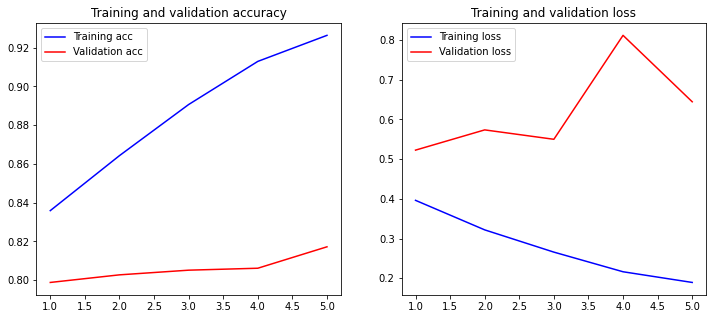

In [56]:
# model.fit(bert_train_dataset, validation_data=bert_val_dataset, epochs=3)
plot_history(history)

In [59]:
predictions = model.predict(val_ds)
print(predictions[0].shape)
print()
predictions_classes = np.argmax(predictions[0], axis = 1)
for i in range(10):
    print('text: {}\n, actual label: {}, predicted label: {}'.format(X_and_Y_test.iloc[i]['text'], val_input_examples[i].label, predictions_classes[i]))

(9943, 2)

comment: های دوستان کمیاب دارو ببینید داروخانه
, actual label: 0.0, predicted label: 0
comment: مراکز عکسو این انسولین پیدا دست می شه ظاهرا برسونید
, actual label: 0.0, predicted label: 0
comment: های پیدا کشتندوسوختندوبردند اختصاص انتخاب سال برای سرکوب دست کند برچیده کثیف میهن انها این میتواند خرج عظیم اراده قطع گروگان ملت سرمایه عزم تروریسم میشود بیش دستگاه ازسرمایه اخوندها شودتا کندوباید
, actual label: 1.0, predicted label: 1
comment: وطن ایران کنار پرس عراق فرستادن کشور خامنه ای سر تازی نخواهند شد گذاشت#گذار رژیم پادشاه این کامیون ملت ازاد لاریجان کرد#کن شاهرود اخوندا نوع مذهب
, actual label: 1.0, predicted label: 1
comment: ایران بود#باش موشک های اسلام دستمون زیاد خیلی خوراک بودجه می گویم کاش ای خورد#خور صادقانه مبارزه اینصورت علنی جمهوری می بود می رسد باز پول سلاح دولت داشت#دار سخنگو شفاف هزینه صریح
, actual label: 0.0, predicted label: 0
comment: ایران بهداشت داشت#دار میکند منتشر اطلاعات نوع وزارت رسم امار
, actual label: 0.0, predicted label: 0
comment: شدگان ابان ک

In [60]:
#Convert the test examples into Bert compatible format.
def example_to_features_predict(input_ids, attention_masks, token_type_ids):
    """
        Convert the test examples into Bert compatible format.
    """
    return {"input_ids": input_ids,
            "attention_mask": attention_masks,
            "token_type_ids": token_type_ids}


In [63]:

def get_prediction(in_sentences):
    """
        Prepare the test comments and return the predictions.
    """
    label_list = [0.0, 1.0]
    input_examples = [InputExample(guid="", text_a = x, text_b = None, label = 0.0) for x in in_sentences] # here, "" is just a dummy label
    predict_input_fn = glue_convert_examples_to_features(examples=input_examples, tokenizer=tokenizer, max_length=MAX_SEQ_LENGTH, task='mrpc', label_list=label_list)
    x_test_input, y_test_input = my_solution(predict_input_fn)
    test_ds   = tf.data.Dataset.from_tensor_slices((x_test_input[0], x_test_input[1], x_test_input[2])).map(example_to_features_predict).batch(32)

    predictions = model.predict(test_ds)
    #   print('predictions:', predictions[0].shape)
    predictions_classes = np.argmax(predictions[0], axis = 1)
    return [(sentence, prediction) for sentence, prediction in zip(in_sentences, predictions_classes)]

In [69]:
#Prepare the test comments and return the predictions

pred_sentences = []
i = 0
while(i<20):
  for tweet in X_and_Y_test.text:
    pred_sentences.append(tweet)
    i +=1
predictions = get_prediction(pred_sentences)
for p in predictions:
    print(p)

Streaming output truncated to the last 5000 lines.
انسولین رسانه خودشون دیابت حالا واسه سر با بایکوت داستان پاره یه کوچه چیه رو خبر نمیدونم دارن رفت#رو تیکه داشت#دار خرید#خر میکنن
می کنم ماه باز بهداشت دهان مقصر پای وزیر می ک… خواهم گفت نوشت#نویس روز شکستی التماس
این انسولین حیا ا شرم نزد صدا تو او… مملکت نیست وژدان ن هیچ ساله مسولین
ایران هفته روشن درخواست گذشته بنرهای کردن عدالت برای زندان اوری فراخوان رژیم انها خیابان این شمع دلیل فرستاد#فرست کرد#کن جمع قربان ترسید#ترس می
قاچاق اخوند دارو دیابت موهوم منطقه کشور همزمان برای کمبود جشن میکنند صادارت جنگ افروزی روحانی رنج حالی که چپاولگر پاسدار پیروزی واردات می گیرد ازادی هموطنان سلاح عزیز میبرند بویژه
جواب درگیره رسید بردارزاده سربار پیشاپیش قلب ممنون نمیدم کاشت#کار برنمیاد ویران بچه اش کامنت داغ برادر خانواده اش می بینم دختر ساله رو از پر پر کرد#کن ساله اش خانواده روز متلاشی
برن دارن بخرن صبح میکشن ملت پولارو اسلحه بیرون
گروهک ولایت پیدا فقیه درمورد رابا مجاهدین کردن میلیون پلای رابطه ورشکسته ایست تن مجرد این وزارتخارجه ولباس پرت سوزن

/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:175: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Streaming output truncated to the last 5000 lines.
('انسولین رسانه خودشون دیابت حالا واسه سر با بایکوت داستان پاره یه کوچه چیه رو خبر نمیدونم دارن رفت#رو تیکه داشت#دار خرید#خر میکنن', 0)
('می کنم ماه باز بهداشت دهان مقصر پای وزیر می ک… خواهم گفت نوشت#نویس روز شکستی التماس', 0)
('این انسولین حیا ا شرم نزد صدا تو او… مملکت نیست وژدان ن هیچ ساله مسولین', 1)
('ایران هفته روشن درخواست گذشته بنرهای کردن عدالت برای زندان اوری فراخوان رژیم انها خیابان این شمع دلیل فرستاد#فرست کرد#کن جمع قربان ترسید#ترس می', 0)
('قاچاق اخوند دارو دیابت موهوم منطقه کشور همزمان برای کمبود جشن میکنند صادارت جنگ افروزی روحانی رنج حالی که چپاولگر پاسدار پیروزی واردات می گیرد ازادی هموطنان سلاح عزیز میبرند بویژه', 0)
('جواب درگیره رسید بردارزاده سربار پیشاپیش قلب ممنون نمیدم کاشت#کار برنمیاد ویران بچه اش کامنت داغ برادر خانواده اش می بینم دختر ساله رو از پر پر کرد#کن ساله اش خانواده روز متلاشی', 0)
('برن دارن بخرن صبح میکشن ملت پولارو اسلحه بیرون', 0)
('گروهک ولایت پیدا فقیه درمورد رابا مجاهدین کردن میلیون پلای رابطه

In [70]:
print("Evaluating the BERT model")
model.evaluate(val_ds)

Evaluating the BERT model
156/156 [==============================] - 90s 576ms/step - loss: 0.6442 - accuracy: 0.8172


[0.6442468762397766, 0.8171578049659729]